In [169]:
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Past 5 year history of Apple stock is downloaded from the Yahoo Finance website as training set. For testing 1 month history for Month of January is used. 
[Link for download.](https://finance.yahoo.com/quote/AAPL/history?period1=1357016400&period2=1514782800&interval=1d&filter=history&frequency=1d)

In [170]:
df_train = pd.read_csv('AAPL-2013-2018.csv')  

In [171]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,79.117142,79.285713,77.375717,78.432854,55.684914,140129500
1,2013-01-03,78.268570,78.524284,77.285713,77.442856,54.982059,88241300
2,2013-01-04,76.709999,76.947144,75.118568,75.285713,53.450539,148583400
3,2013-01-07,74.571426,75.614288,73.599998,74.842857,53.136124,121039100
4,2013-01-08,75.601425,75.984283,74.464287,75.044289,53.279137,114676800


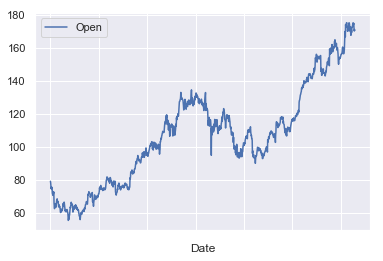

In [172]:
df_train.plot(x='Date',y='Open')

In [173]:
df_train.shape

(1259, 7)

**Filtering data**

For prediction purposes, only stock price at opening of stock market for that day is of interest. So only this columns value is retained and all other columns are not used. 

In [174]:
df_train_processed = df_train.iloc[:, 1:2].values

In [175]:
df_train_processed[0]

array([79.117142])

**Feature Scaling**

Data is then scaled with minmax scalar transformation in the range of 0-1

In [176]:
scaler = MinMaxScaler(feature_range = (0, 1))
df_train_scaled = scaler.fit_transform(df_train_processed)

**Data manipulation**

For time series prediction, past 60 day data is used to predict stock price at 61st day. 

Following function modifies input data to create feature set and labels. Each feature set contains 60 observations and corresponding stock price for next day. 

In [177]:
features_set = []  
labels = []  
for i in range(60, 1259):  
    features_set.append(df_train_scaled[i-60:i, 0])
    labels.append(df_train_scaled[i, 0])

In [178]:
features_set, labels = np.array(features_set), np.array(labels)  

In [179]:
features_set.shape

(1199, 60)

In [180]:
labels.shape

(1199,)

For data to be read by LSTM, it is necessary to reshape the data in the format as required, which will be Nrows x Ncolumns x 1. Number 1 used here because we are predicting one feature.  

In [181]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [182]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 

In [183]:
model = Sequential()

model.add(LSTM(units=60, return_sequences=True))  #Return_sequences=true as we add more layers to the model
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=60))  
model.add(Dropout(0.2)) 
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [184]:
model.fit(features_set, labels, epochs = 100, batch_size = 30)  

Epoch 1/100
1199/1199 [==============================] - 7s 6ms/step - loss: 0.0374
Epoch 2/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0040
Epoch 3/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0033
Epoch 4/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0036
Epoch 5/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0033
Epoch 6/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0030
Epoch 7/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0027
Epoch 8/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0028
Epoch 9/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0026
Epoch 10/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0028
Epoch 11/100
1199/1199 [==============================] - 5s 4ms/step - loss: 0.0027
Epoch 12/100
1199/1199 [==============================] - 5s 4ms/step - lo

1199/1199 [==============================] - 5s 4ms/step - loss: 9.5271e-04
Epoch 98/100
1199/1199 [==============================] - 5s 4ms/step - loss: 8.7528e-04
Epoch 99/100
1199/1199 [==============================] - 5s 4ms/step - loss: 9.0177e-04
Epoch 100/100
1199/1199 [==============================] - 5s 4ms/step - loss: 8.5112e-04


**Model predictions**

LSTM model is now used to predicting stock prices for month of January 2018.  

In [185]:
df_test = pd.read_csv('AAPL-Jan18.csv')  
df_test_processed = df_test.iloc[:, 1:2].values  #Again dropping the columns except 'Open'

In [186]:
df_test.shape

(21, 7)

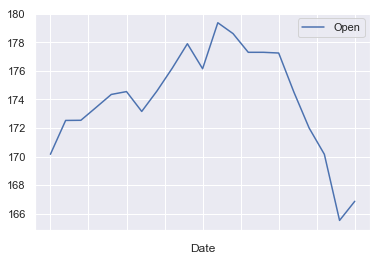

In [187]:
df_test.plot(x='Date',y='Open')

For each of the 21 days, we need corresponding 60 days historical data. This will enable us to predict the stock price for that day by passing historical data to the model. 

In [285]:
df_combined = pd.concat((df_train['Open'], df_test['Open']), axis=0)  
test_inputs = df_combined[len(df_combined) - len(df_test) - 60:].values  

In [286]:
test_inputs[0:5]

array([154.179993, 154.970001, 155.809998, 156.059998, 155.970001])

In [287]:
test_inputs = test_inputs.reshape(-1,1)
test_plot = test_inputs
test_inputs[0:5]

array([[154.179993],
       [154.970001],
       [155.809998],
       [156.059998],
       [155.970001]])

In [288]:
test_inputs = scaler.transform(test_inputs) # Scaling the data with MinMax scaler

In [289]:
test_features = []  
for i in range(60, 81):  
    test_features.append(test_inputs[i-60:i, 0])

In [290]:
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1)) 

In [291]:
predictions = model.predict(test_features)  

In [292]:
predictions = scaler.inverse_transform(predictions)

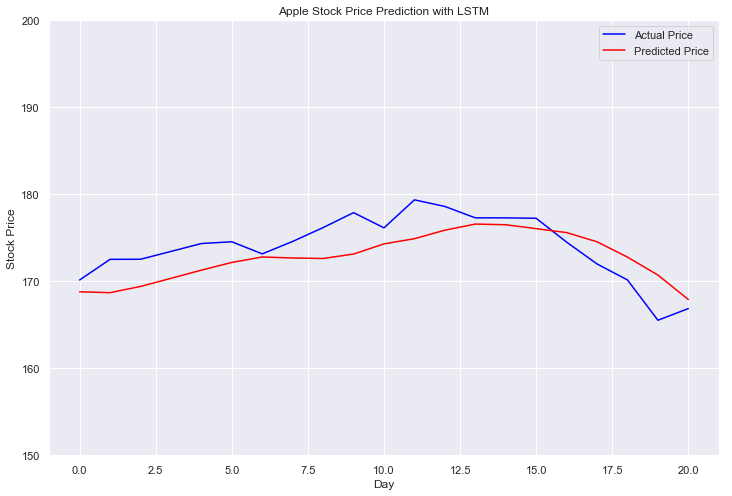

In [293]:
plt.figure(figsize=(12,8))  
plt.plot(apple_testing_processed, color='blue', label='Actual Price')  
plt.plot(predictions, color='red', label='Predicted Price')  
plt.title('Apple Stock Price Prediction with LSTM')  
plt.xlabel('Day')  
plt.ylabel('Stock Price') 
plt.ylim(150,200)
plt.legend()  
plt.show()

In [294]:
from sklearn.metrics import mean_squared_error
import math

error = math.sqrt(mean_squared_error(predictions,df_test_processed))
print (f'Root mean squared error is ${error:.2f}')

Root mean squared error is $2.81


**Reference**

This notebook is based on the work [here](https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/) and [here](https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68)